In [1]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.


import os
from dotenv import load_dotenv
load_dotenv()
module_path = os.getenv("MODULE_SCENARIO_PATH", default="/app")


import sys
sys.path.insert(0, module_path)

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score


from torch_geometric.nn import TGNMemory
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

from dataclasses import asdict
import scenario_identification.utils.path_helper as path_helper
from scenario_identification.utils.path_helper import DatasetTask, DatasetType, set_constants
import scenario_identification.utils.data_loader as loader

import scenario_identification.visualization.evaluation as presenter 

from scenario_identification.utils.argument_setup import Args
from scenario_identification.utils.path_helper import get_node_embedding_output_folder_path
from scenario_identification.utils.early_stopper import EarlyStopper
from scenario_identification.utils.path_helper import DatasetType, get_model_output_path


from scenario_identification.models.link_predictor.LinearLinkPredictor import LinkPredictor
from scenario_identification.models.tgn.GraphAttentionEmbedding import GraphAttentionEmbedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import pandas as pd

args=Args()

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim
INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES = args.include_artificial_negative_samples



negative_samples_str = "NegativeSamples" if args.include_artificial_negative_samples else "NoNegativeSamples"
experiment_name = f"{args.embedding_module}_Attn_{args.data}_{negative_samples_str}"
report_name = f"evaluation_report_{experiment_name}.txt"

# features_str = "_".join(sorted(node_features + edge_features))


DATASET_TYPE = DatasetType.LINK_PREDICTION_DISTANCE_LABELS.value
DATASET_TASK = DatasetTask.LINK_PREDICTION.value

set_constants(DATASET_TYPE, DATASET_TASK, experiment_name)


In [2]:


dataset_path = path_helper.get_dataset_file_path()
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(columns=['Unnamed: 0'])
if not INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES:
    dataset = dataset[dataset['relationship_label'] != -1]


# dataset

In [3]:
    # node_features_columns = ['dist', 'latitude', 'longitude', 'shape_status_DEFORMED', 
node_features = ['shape_status_DEFORMED', 
                'shape_status_ORIGINAL_MANUFACTURED',  
                'signal', 'speed', 'status_ACTIVE', 'status_ERROR', 
                'status_INACTIVE', 'type_EMERGENCY_CENTER', 
                'type_INDUCTION_LOOP', 'type_SMART_PHONE', 'type_TRAFFIC_CAMERA', 
                'type_TRAFFIC_LIGHT', 'type_VEHICLE']

edge_features = ['dist']

label = 'relationship_label'


# EXPERIMENT_NAME = f"TGN-GraphAttention_bs-Samples_{'only positive' if INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES else 'both'}"





data, slices = loader.process_link_label_dataset(dataset, node_features, edge_features, label)
num_node_features = data.destination_node_features.shape[1]
num_edge_features = data.msg.shape[1]
data

TemporalData(src=[24180], dst=[24180], t=[24180], msg=[24180, 1], y=[24180], destination_node_features=[24180, 13])

Counter({1.0: 16946})


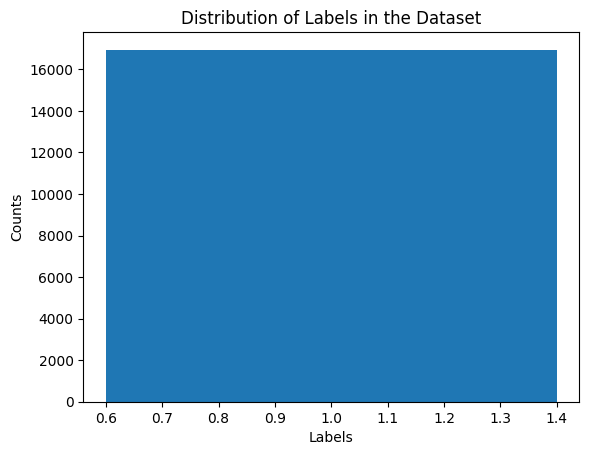

In [4]:


num_features = num_node_features + num_edge_features

train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.10, test_ratio=0.20)

presenter.plot_label_distribution(train_data)

train_loader, val_loader, test_loader = loader.get_temporal_data_loader(train_data, val_data, test_data, args.bs)

In [5]:
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)
memory_dim = time_dim = embedding_dim = num_features

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)


gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)


In [6]:
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

link_pred = LinkPredictor(in_channels=embedding_dim).to(device)
optimizer = torch.optim.Adam(set(memory.parameters()) | set(gnn.parameters()) | set(link_pred.parameters()), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


In [7]:


def train(f):
    memory.train()
    gnn.train()
    link_pred.train()

    memory.reset_state()  
    neighbor_loader.reset_state()  

    total_loss = 0
    overall_batches = len(train_loader)
    
    print(f"Length of batches: {overall_batches}")
    
    for k, batch in enumerate(train_loader):
    
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))
        
        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        
        total_loss += float(loss) * batch.num_events
        
        if k % 100 == 0:
            print(f"Trainings batch loaded: {k} / {overall_batches}""")
            f.write(f"Trainings batch loaded: {k} / {overall_batches}\n")

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader,f):
    memory.eval()
    gnn.eval()
    link_pred.eval()

    total_loss = 0
    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.
    
    overall_batches = len(loader)
    aps, aucs = [], []
    
    ground_truth, predictions = [], []
    
    for k, batch in enumerate(loader):
    
        batch = batch.to(device)
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        
        pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
        neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

        y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
        y_true = torch.cat(
            [torch.ones(pos_out.size(0)),
             torch.zeros(neg_out.size(0))], dim=0)
        
        loss = criterion(pos_out, torch.ones_like(pos_out))
        loss += criterion(neg_out, torch.zeros_like(neg_out))
        
        ground_truth.extend(y_true)
        predictions.extend(y_pred)

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
        
        total_loss += float(loss) * batch.num_events
        if k % 100 == 0:
            print(f"Test batch loaded: {k} / {overall_batches}""")
            f.write(f"Test batch loaded: {k} / {overall_batches}\n")
        
        
    total_loss = total_loss / train_data.num_events
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), total_loss, ground_truth, predictions 

train_losses = []
validation_losses = []


# Initialize lists to store metrics over epochs
accuracy_list = []
f1_score_list = []
recall_list = []
precision_list = []


trainings_log_file = path_helper.get_trainings_logs_path()

trainings_logs = None
try: 
    trainings_logs = open(trainings_log_file, "w")
except:
    print("Could not open file")
    exit(1)


for epoch in range(1, args.n_epoch + 1):
    train_loss = train(trainings_logs)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        n_id = torch.arange(memory.num_nodes, device=device)  # assuming memory has num_nodes attribute to get all nodes
        embeddings, _ = memory(n_id)
        output_path_node_embedding = get_node_embedding_output_folder_path()
        presenter.plot_embeddings(embeddings, epoch=5, folder_path=output_path_node_embedding, file_name=f'Node_Embedding_Epoch_{epoch}.png')
    
    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    trainings_logs.write(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}\n')
    
    
    val_ap, val_auc, val_loss, _, _ = test(val_loader,trainings_logs)
    validation_losses.append(val_loss)    
    test_ap, test_auc, test_loss, ground_truth , predictions = test(test_loader,trainings_logs)
    
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')
    trainings_logs.write(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}\n')
    trainings_logs.write(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}\n')
    
    if early_stopper.early_stop(val_loss):         
        print(f"Early stopping: {epoch} epochs")
        trainings_logs.write(f"Early stopping: {epoch} epochs")    
        break
    
    ground_truth = [int(t.item()) for t in ground_truth]
    predictions_binary = [int(t.item() >= 0.5) for t in predictions]


    accuracy = accuracy_score(ground_truth, predictions_binary)
    f1 = f1_score(ground_truth, predictions_binary)
    recall = recall_score(ground_truth, predictions_binary)
    precision = precision_score(ground_truth, predictions_binary)

    # Append metrics to lists
    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)
    precision_list.append(precision)
    
    
    # print(f"Classification Report:\n{classification_report(ground_truth, predictions_binary)}")
    # print(f"Accuracy: {accuracy}")

    trainings_logs.write(f"Classification Report:\n{classification_report(ground_truth, predictions_binary)}\n")
    trainings_logs.write(f"Accuracy: {accuracy}\n")

trainings_logs.close()

presenter.plot_evaluation_results(accuracy_list, f1_score_list, recall_list, precision_list)
presenter.plot_trainings_loss(train_losses, validation_losses)

model_output_path = get_model_output_path()
torch.save(gnn.state_dict(), model_output_path)


presenter.plot_evaluation_results(accuracy_list, f1_score_list, recall_list, precision_list)
presenter.plot_trainings_loss(train_losses, validation_losses)

model_output_path = path_helper.get_model_output_path()
torch.save(gnn.state_dict(), model_output_path)



Length of batches: 530


RuntimeError: could not create a primitive descriptor for a matmul primitive

In [ ]:
presenter.generate_confusion_matrix(ground_truth, predictions_binary)
presenter.generate_roc_curve(ground_truth, predictions_binary)

In [ ]:
def write_report_to_file():
    report_path = path_helper.get_experiment_report_path()
    
    with open(report_path, "w") as f:
        # Information of dataset
        f.write("=== Information of Dataset ===\n")
        f.write(f"{'Dataset Type':<35}{DATASET_TYPE}\n")
        f.write(f"{'Dataset Task':<35}{DATASET_TASK}\n")
        f.write(f"{'Dataset Path':<35}{dataset_path}\n\n")
        f.write(f"{'Negative Relationship Labels Considered:':<35} {INCLUDE_ARTIFICAL_NEGATIVE_SAMPLES}\n")

        # Number of edges and nodes
        f.write("=== General Stats ===\n")
        f.write(f"{'Number of Edges':<35}{data.num_edges}\n")
        f.write(f"{'Number of Nodes':<35}{data.num_nodes}\n\n")
        
        # Selected features
        f.write("=== Features ===\n")
        f.write("Node Features:\n")
        for feature in node_features:
            f.write(f"- {feature}\n")
        f.write("\nEdge Features:\n")
        for feature in edge_features:
            f.write(f"- {feature}\n\n")
        
        f.write(f"{'Label':<35}{label}\n")
        f.write(f"{'Did consider negative relationship_labels':<35}{dataset['relationship_label'].min() < 0}\n\n")
        
        f.write("=== Set Arguments ===\n")
      
        args_dict = asdict(args)    
        for key, value in args_dict.items():
            f.write(f"{key:<35}: {value}\n")
        f.write("\n")
        
        # Model Information
        f.write("=== Model Information ===\n")
        f.write(f"{'Model':<35}TGN with Graph Attention Embedding\n")
        f.write(f"{'Memory Dimension':<35}{MEMORY_DIM}\n")
        f.write(f"{'Node Dimension':<35}{NODE_DIM}\n")
        # ... (other model initialization settings)
        f.write("\n")
        
        # Results
        f.write("=== Results ===\n")
        f.write(f"{'Final Validation AP':<35}{val_ap}\n")
        f.write(f"{'Final Validation AUC':<35}{val_auc}\n")
        f.write(f"{'Final Test AP':<35}{test_ap}\n")
        f.write(f"{'Final Test AUC':<35}{test_auc}\n")
        f.write(f"{'Final Accuracy':<35}{accuracy}\n")
        f.write(f"{'Final F1':<35}{f1}\n")
        f.write(f"{'Final Recall':<35}{recall}\n")
        f.write(f"{'Final Precision':<35}{precision}\n")
        f.write(f"{'Final Loss':<35}{test_loss}\n")
        f.write("\n")

        
        
write_report_to_file()
